# **CLEANING**

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("dataset.csv")

df = df.drop_duplicates()

for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

numeric_cols = df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    mean = df[col].mean()
    std = df[col].std()
    df = df[(df[col] >= mean - 3*std) & (df[col] <= mean + 3*std)]

df.reset_index(drop=True, inplace=True)

df.to_csv("cleaned_data.csv", index=False)

/tmp/ipython-input-3493211705.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-3493211705.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

## **MODEL TRAINING,EVALUATION AND GRAPHS**

Dataset Loaded Successfully!
5-Fold CV R²: 0.9979

Model Evaluation:
R² Score: 0.9985
MAE: 1.27
RMSE: 2.10

95% Confidence Intervals:
                                              0         1
MODELYEAR                              0.002796  0.002813
MAKE                                  -0.037625  0.009329
MODEL                                 -0.893901  0.015685
ENGINESIZE                            -0.001369  0.001094
CYLINDERS                              0.000077  0.002157
FUELCONSUMPTION_CITY                  -0.009504  0.008062
FUELCONSUMPTION_HWY                   -0.007702  0.006776
FUELCONSUMPTION_COMB                   0.031033  0.062814
FUELCONSUMPTION_COMB_MPG              -0.018342 -0.017728
VEHICLECLASS_FULL-SIZE                -0.001744  0.002562
VEHICLECLASS_MID-SIZE                 -0.001078  0.002111
VEHICLECLASS_MINICOMPACT              -0.002087  0.003989
VEHICLECLASS_MINIVAN                   0.001081  0.008906
VEHICLECLASS_PICKUP TRUCK - SMALL      0.003862  0.013

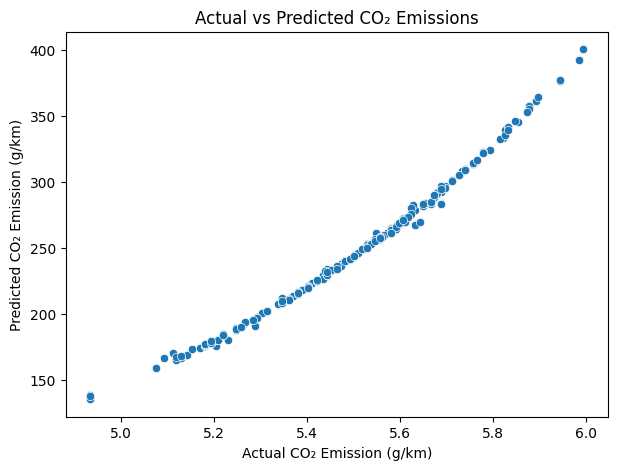

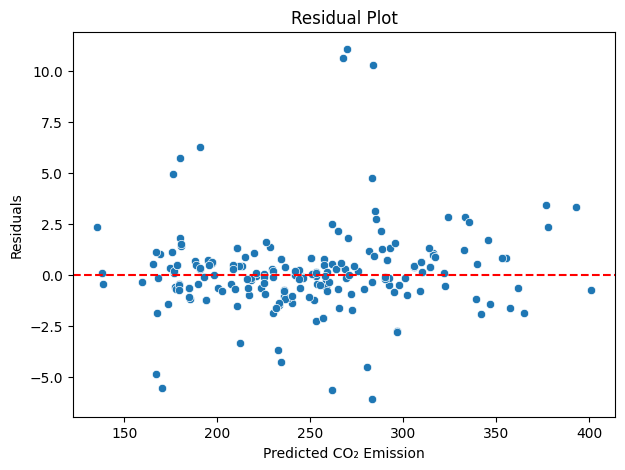

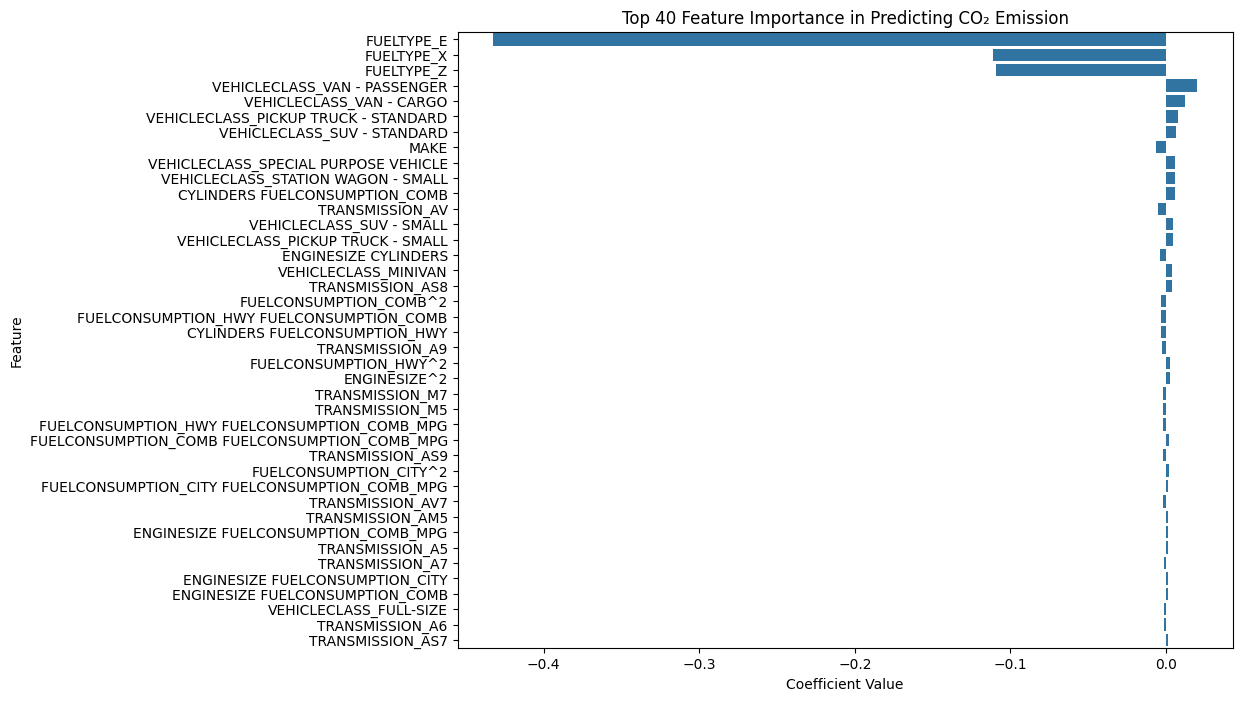


Insights:
- The most influential feature on CO₂ emission is 'FUELTYPE_E' with coefficient -0.43.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-1364483586.py:178: FutureWarning: 

The `ci` parameter

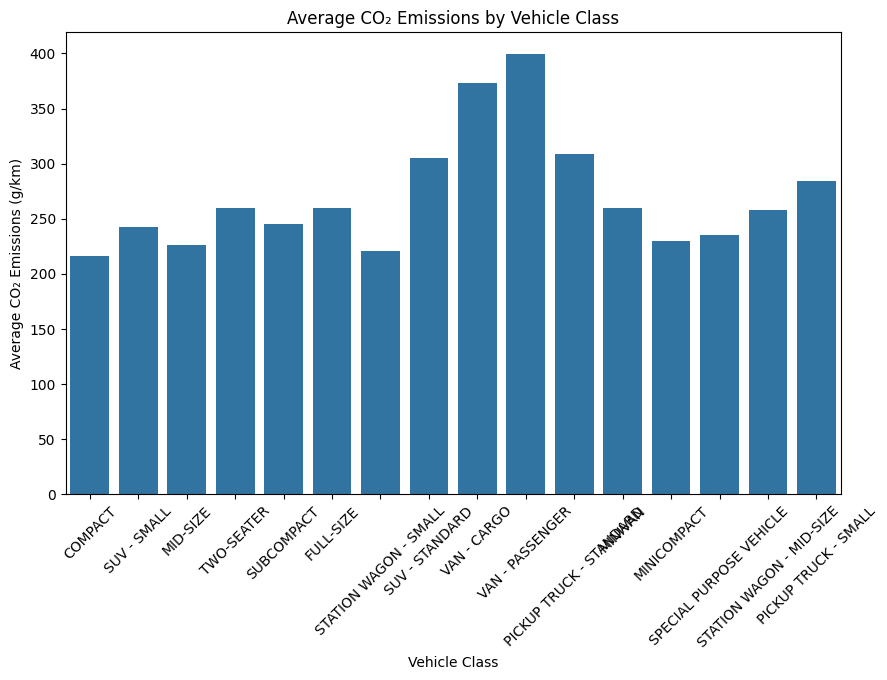

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm


data = pd.read_csv("cleaned_data.csv")
print("Dataset Loaded Successfully!")


numeric_cols = [
    'MODELYEAR',
    'ENGINESIZE',
    'CYLINDERS',
    'FUELCONSUMPTION_CITY',
    'FUELCONSUMPTION_HWY',
    'FUELCONSUMPTION_COMB',
    'FUELCONSUMPTION_COMB_MPG'
]

categorical_cols = [
    'MAKE',
    'MODEL',
    'VEHICLECLASS',
    'TRANSMISSION',
    'FUELTYPE'
]


for col in ['MAKE', 'MODEL']:
    freq = data[col].value_counts(normalize=True)
    data[col] = data[col].map(freq)

data = pd.get_dummies(
    data,
    columns=['VEHICLECLASS', 'TRANSMISSION', 'FUELTYPE'],
    drop_first=True
)


for col in numeric_cols + ['CO2EMISSIONS']:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.dropna(inplace=True)


X = data.drop(['CO2EMISSIONS'], axis=1)
y = np.log1p(data['CO2EMISSIONS'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


poly = PolynomialFeatures(degree=2, include_bias=False)

X_train_poly = poly.fit_transform(X_train[numeric_cols])
X_test_poly = poly.transform(X_test[numeric_cols])

X_train_poly_df = pd.DataFrame(
    X_train_poly,
    columns=poly.get_feature_names_out(numeric_cols),
    index=X_train.index
)

X_test_poly_df = pd.DataFrame(
    X_test_poly,
    columns=poly.get_feature_names_out(numeric_cols),
    index=X_test.index
)


X_train_cat = X_train.drop(columns=numeric_cols)
X_test_cat = X_test.drop(columns=numeric_cols)

X_train_final = pd.concat([X_train_poly_df, X_train_cat], axis=1)
X_test_final = pd.concat([X_test_poly_df, X_test_cat], axis=1)


model = Ridge(alpha=1.0)
model.fit(X_train_final, y_train)

cv_scores = cross_val_score(
    model, X_train_final, y_train, cv=5, scoring='r2'
)
print(f"5-Fold CV R²: {cv_scores.mean():.4f}")

y_pred_log = model.predict(X_test_final)
y_pred = np.expm1(y_pred_log)
y_test_orig = np.expm1(y_test)

r2 = r2_score(y_test_orig, y_pred)
mae = mean_absolute_error(y_test_orig, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))

print("\nModel Evaluation:")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

X_train_sm = X_train_sm.astype(float)
y_train = y_train.astype(float)

ols_model = sm.OLS(y_train, X_train_sm).fit()

print("\n95% Confidence Intervals:")
print(ols_model.conf_int(alpha=0.05))


plt.figure(figsize=(7,5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual CO₂ Emission (g/km)")
plt.ylabel("Predicted CO₂ Emission (g/km)")
plt.title("Actual vs Predicted CO₂ Emissions")
plt.show()


residuals = y_test_orig - y_pred
plt.figure(figsize=(7,5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted CO₂ Emission")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


coefficients = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Coefficient': model.coef_
})

coefficients['Importance'] = coefficients['Coefficient'].abs()

coefficients.sort_values(by='Importance', ascending=False, inplace=True)

top_features = coefficients.head(40)

plt.figure(figsize=(10,8))
sns.barplot(x='Coefficient', y='Feature', data=top_features)
plt.title("Top 40 Feature Importance in Predicting CO₂ Emission")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()


print("\nInsights:")
top_feature = coefficients.iloc[0]
print(f"- The most influential feature on CO₂ emission is '{top_feature['Feature']}' "
      f"with coefficient {top_feature['Coefficient']:.2f}.")

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

bins = [0, 150, 250, np.inf]
y_test_bin = np.digitize(y_test, bins)
y_pred_bin = np.digitize(y_pred, bins)


class_report = classification_report(y_test_bin, y_pred_bin)


data = pd.read_csv("cleaned_data.csv")

numeric_cols = data.select_dtypes(include=['number']).columns


plt.figure(figsize=(10,6))
sns.barplot(x='VEHICLECLASS', y='CO2EMISSIONS', data=data, estimator='mean', ci=None)
plt.title("Average CO₂ Emissions by Vehicle Class")
plt.xlabel("Vehicle Class")
plt.ylabel("Average CO₂ Emissions (g/km)")
plt.xticks(rotation=45)
plt.show()

print()
print()

### **PROTOTYPE**

In [ ]:



import pandas as pd
import numpy as np

print("AI-Based CO₂ Emission Prediction System (Prototype)\n")


model_year = int(input("Enter Model Year: "))
make = input("Enter MAKE: ").upper()
model_name = input("Enter MODEL: ").upper()
vehicle_class = input("Enter VEHICLE CLASS: ").upper()

engine_size = float(input("Enter ENGINE SIZE (Litres): "))
cylinders = int(input("Enter CYLINDERS: "))
transmission = input("Enter TRANSMISSION (e.g., A6, M6): ").upper()
fuel_type = input("Enter FUEL TYPE (X / Z / D / E / N): ").upper()

fuel_city = float(input("Enter FUEL CONSUMPTION CITY (L/100km): "))
fuel_hwy = float(input("Enter FUEL CONSUMPTION HWY (L/100km): "))
fuel_comb = float(input("Enter FUEL CONSUMPTION COMB (L/100km): "))
fuel_mpg = float(input("Enter FUEL CONSUMPTION COMB MPG: "))


raw_input = pd.DataFrame([{
    'MODELYEAR': model_year,
    'MAKE': make,
    'MODEL': model_name,
    'VEHICLECLASS': vehicle_class,
    'ENGINESIZE': engine_size,
    'CYLINDERS': cylinders,
    'TRANSMISSION': transmission,
    'FUELTYPE': fuel_type,
    'FUELCONSUMPTION_CITY': fuel_city,
    'FUELCONSUMPTION_HWY': fuel_hwy,
    'FUELCONSUMPTION_COMB': fuel_comb,
    'FUELCONSUMPTION_COMB_MPG': fuel_mpg
}])




for col in ['MAKE', 'MODEL']:
    freq = data[col].value_counts(normalize=True)
    raw_input[col] = raw_input[col].map(freq).fillna(0)


raw_input = pd.get_dummies(
    raw_input,
    columns=['VEHICLECLASS', 'TRANSMISSION', 'FUELTYPE'],
    drop_first=True
)


numeric_input = raw_input.reindex(
    columns=poly.feature_names_in_,
    fill_value=0
)
numeric_poly = poly.transform(numeric_input)

numeric_poly = poly.transform(numeric_input)

numeric_poly_df = pd.DataFrame(
    numeric_poly,
    columns = poly.get_feature_names_out(poly.feature_names_in_)

)


categorical_input = raw_input.drop(
    columns=[c for c in numeric_cols if c in raw_input.columns]
).reset_index(drop=True)

X_proto = pd.concat([numeric_poly_df, categorical_input], axis=1)


X_proto = X_proto.reindex(columns=X_train_final.columns, fill_value=0)


predicted_log = model.predict(X_proto)
predicted_co2 = np.expm1(predicted_log)[0]


print(f"Predicted CO₂ Emission: {predicted_co2:.2f} g/km")


AI-Based CO₂ Emission Prediction System (Prototype)

Enter Model Year: 2014
Enter MAKE: KIA
Enter MODEL: FORTE KOUP
Enter VEHICLE CLASS: COMPACT
Enter ENGINE SIZE (Litres): 2
Enter CYLINDERS: 4
Enter TRANSMISSION (e.g., A6, M6): M6
Enter FUEL TYPE (X / Z / D / E / N): X
